## Action needed, set parameters!
For the first experiment, we used: 
- network_group = "Res18"
- experiment = 1
- filter_errors = True
- num_images = 80
- new_indices = False

For the second experiment, we used: 
- network_group = "Rebuttal"
- experiment = 2
- filter_errors = True
- num_images = 100
- new_indices = True

In [1]:
# Set network group
network_group = "Rebuttal" # Either: "Res18" (for ResNet-18 variants) or "Rebuttal" (SOTA models)

# Set which experiment you want to export images for
experiment = 2 # Either: 1 (discerning trivial and impossible images) or 2 (rating 3 properties of images)

# Decide if you want to filter out images with label errors (we did it for Experiment 1 but not 2)
filter_errors = False # Either: False (do not filter) or True (do filter)

# How many images do you want to export for each condition?
num_images = 100 # Int

# Decide whether to use old or new error indices
new_indices = False # Bool

## Imports and function definitions

In [2]:
# Imports
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scripts.analysis_helpers import load_data, prep_condition, order_econs
from scripts.analysis_helpers import main_plot, three_plots, heat_plot, plot_decisions, plot_decisions_change, main_plot_both
from scripts.analysis_helpers import calc_econ
from scripts.data import init_dataset
import seaborn as sns

# Keep local packages updated
%load_ext autoreload
%autoreload 2

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        
        return tuple_with_path
    
def init_dataset(DSET, NUM, DATA, MODEL, CONDITION, train=True):
    """
    :param DSET: Which dataset to use
    :param NUM: Model index
    :param DATA: Whether to use same or different datasets
    :param train: Whether to choose train or test dataset
    :return: Initialized dataset
    """

    # Check which dataset is supposed to be used
    if DSET == "ImageNet":

        # Dataset location
        data_dir = '/scratch_local/datasets/ImageNet2012/'

        # Check whether train or validation dataset is needed
        if train is True:
            path = os.path.join(data_dir, 'train')

            # Initialize dataset and apply transforms
            dataset = ImageFolderWithPaths(
                path,
                transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    #normalize,
                ]))

        elif train is False:
            path = os.path.join(data_dir, 'val')

            # Initialize dataset and apply transforms
            dataset = ImageFolderWithPaths(
                path,
                transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    #normalize,
                ]))
            
    
    if DSET == "CIFAR100":

        # Dataset location
        data_dir = '/home/wichmann/lschulzebuschoff43/cifar100/'

        # Set normalization parameters
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     
        # Check whether train or validation dataset is needed
        if train is True:
            path = os.path.join(data_dir, 'train')

            # Initialize dataset and apply transforms
            dataset = datasets.ImageFolder(
                path,
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(32, 4),
                    transforms.ToTensor(),
                    normalize,
                ]))

        elif train is False:
            path = os.path.join(data_dir, 'val')

            # Initialize dataset and apply transforms
            dataset = datasets.ImageFolder(
                path,
                transforms.Compose([
                    transforms.ToTensor(),
                    #normalize,
                ]))

    return dataset

## 0. Initiate data set, load data files and indexing files

In [4]:
# Initiate validation data set
val_set = init_dataset("ImageNet", _, _, _, _, train=False)

# Load data file specific to model group
mean_decisions_correct = np.load(f"{network_group}_mean_decisions_correct.npy")

# Order data from images with 0 networks getting them correct to all getting them correct (0 to 1)
clean_order = np.flip((mean_decisions_correct[:,-1]).argsort())

# Load identification file, which allows mapping of classes from image index
idents = np.load('imagenet_val_ident.npy', allow_pickle=True)

# Load identification file, which allows mapping class numbers to class names
names = np.loadtxt('imagenet_ident_class.txt', dtype="str", delimiter=":")
    
# Filter errors if it is wanted
if filter_errors:
    
    # Check if new error indices are to be used
    if new_indices:
    
        # Load error file and get indices where errors are supposed to be
        label_error = np.load("imagenet_val_ident_2.npy", allow_pickle=True)
        error_inds = np.where(label_error == 1)
    
    # For old error indices
    else:
        
        # Load error files and get indices where errors are supposed to be
        label_error_new = np.load("imagenet_val_ident_2.npy", allow_pickle=True)
        label_error_old = np.load("imagenet_val_ident.npy", allow_pickle=True)[:, 2].astype(np.int)
        label_error = label_error_new + label_error_old
        error_inds = np.where(label_error > 0)

    # Check if label errors correspond to actual errors
    for item in error_inds[0][0:5]:
        
        # Get class name of current item
        image_class_ident = idents[item, 1].split("/")[0]
        image_class_name = str(names[np.where(names[:, 0] == image_class_ident), 1]).split("'")[1]

        # Print information about item
        print(f"Image {item}, Class {image_class_name}")

        # Plot item
        image = np.transpose(val_set[item][0].cpu().detach().numpy(), (1, 2, 0))
        plt.imshow(image)
        plt.show()
    
    # Filter errors
    mean_decisions_correct = mean_decisions_correct[np.where(label_error == 0)]

## 1. Get images for experiment 1

In [5]:
# Define plotting function for first experiment
def plot_exp_1(indexNumber,imageEasy, imageImpossible, Training=False):
    
    # General plot settings
    plt.close()
    plt.figure(figsize=(20,16))
    plt.axis('on')
    
    # Randomly decide if easy or hard image should be right or left 
    # Above 0.5, left image is easy, otherwise left image is hard
    LeftRight = np.random.rand()

    # First subplot
    ax = plt.subplot(121)
    if(LeftRight>0.5): 
        if(Training==True):
            ax.patch.set_edgecolor('green')  
            ax.patch.set_linewidth('50')
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        plt.imshow(imageEasy)
    else:
        plt.imshow(imageImpossible)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    plt.axis('on')
    plt.title('L', fontsize=50)
    plt.ylabel(str(indexNumber), fontsize=50,rotation=0)
    plt.xticks([], [])
    plt.yticks([], [])
    ax.yaxis.set_label_coords(-0.2,0.5)

    # Second subplot
    ax = plt.subplot(122)
    if(LeftRight>0.5): 
        plt.imshow(imageImpossible)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    else:
        if(Training==True):
            ax.patch.set_edgecolor('green')  
            ax.patch.set_linewidth('50') 
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        plt.imshow(imageEasy)

    # Tick settings
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('R', fontsize=50)
    
    # Save image to folder
    if Training==True:
        plt.savefig('./experiment1/ExpImage_train_' + str(indexNumber) + '.jpg')
    else:
        plt.savefig('./experiment1/ExpImage_' + str(indexNumber) + '.jpg')
    
    # Return index of easy image
    if(LeftRight > 0.5):
        return 'l'
    else:
        return 'r'

In [6]:
# If you want to export the "good" and "bad" images for the first psychophysical experiment:
if experiment == 1:
    
    # Settings for experiment 1
    num_samples = num_images
    np.random.seed(1312)

    # Pre-allocate answers dataframe
    answers = np.zeros((num_samples), dtype="object")

    # Get indices of random bad and good images
    bad_inds = np.random.choice(np.flip(clean_order)[0:1000], size=num_samples, replace=False)
    good_inds = np.random.choice(clean_order[0:1000], size=num_samples, replace=False)

    # Get 80 images from trivials and impossibles and + 5 for each condition for training
    for index in range(num_samples+5):

        # Get respective image from validation set
        image_good = np.transpose(val_set[good_inds[index]][0].cpu().detach().numpy(), (1, 2, 0))
        image_bad = np.transpose(val_set[bad_inds[index]][0].cpu().detach().numpy(), (1, 2, 0))

        # First five images are for training
        while index < 5:
            
            # Use plotting function defined above
            answers[index] = plot_exp_1("Training", image_good, image_bad, Training=False)
        
        # Later images are for real experiment, therefore training flag is turned to False
        else:
            
            # With index-4, first test image is labelled as image 1
            answers[index] = plot_exp_1(index-4, image_good, image_bad, Training=False)
            
    # Save answers dataframe to same folder
    np.save("'./experiment1/locations", answers)

## 2. Get images for experiment 2

In [7]:
# Define plotting function for first experiment
def plot_exp_2(index, image, training=False, new_indices=False):
    
    # General figure settings
    plt.close()
    plt.figure(figsize=(20,16))
    plt.axis('on')
    ax = plt.subplot(111) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Show image
    plt.imshow(image)
    
    # Axis settings
    plt.ylabel(str(index).replace("_", " "), fontsize=50,rotation=0)
    plt.xticks([], [])
    plt.yticks([], [])
    ax.yaxis.set_label_coords(-0.2,0.5)

    # Check if new error indices are to be used
    if new_indices:
        
        # Check if it is a training image, add 0 to filename so that it appears first in folder
        if training:
            plt.savefig(f'./experiment2_newerrs/0_ExpImage_{str(index)}.jpg')
        else:
            plt.savefig(f'./experiment2_newerrs/ExpImage_{str(index)}.jpg')
    
    # Same for old error indices
    else:
        if training:
            plt.savefig(f'./experiment2/0_ExpImage_{str(index)}.jpg')
        else:
            plt.savefig(f'./experiment2/ExpImage_{str(index)}.jpg')

In [8]:
new_indices = True

Generating image 1 of 306


/home/wichmann/lschulzebuschoff43/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Generating image 2 of 306
Generating image 3 of 306
Generating image 4 of 306
Generating image 5 of 306
Generating image 6 of 306
Generating image 7 of 306
Generating image 8 of 306
Generating image 9 of 306
Generating image 10 of 306
Generating image 11 of 306
Generating image 12 of 306
Generating image 13 of 306
Generating image 14 of 306
Generating image 15 of 306
Generating image 16 of 306
Generating image 17 of 306
Generating image 18 of 306
Generating image 19 of 306
Generating image 20 of 306
Generating image 21 of 306
Generating image 22 of 306
Generating image 23 of 306
Generating image 24 of 306
Generating image 25 of 306
Generating image 26 of 306
Generating image 27 of 306
Generating image 28 of 306
Generating image 29 of 306
Generating image 30 of 306
Generating image 31 of 306
Generating image 32 of 306
Generating image 33 of 306
Generating image 34 of 306
Generating image 35 of 306
Generating image 36 of 306
Generating image 37 of 306
Generating image 38 of 306
Generatin

Generating image 300 of 306
Generating image 301 of 306
Generating image 302 of 306
Generating image 303 of 306
Generating image 304 of 306
Generating image 305 of 306
Generating image 306 of 306


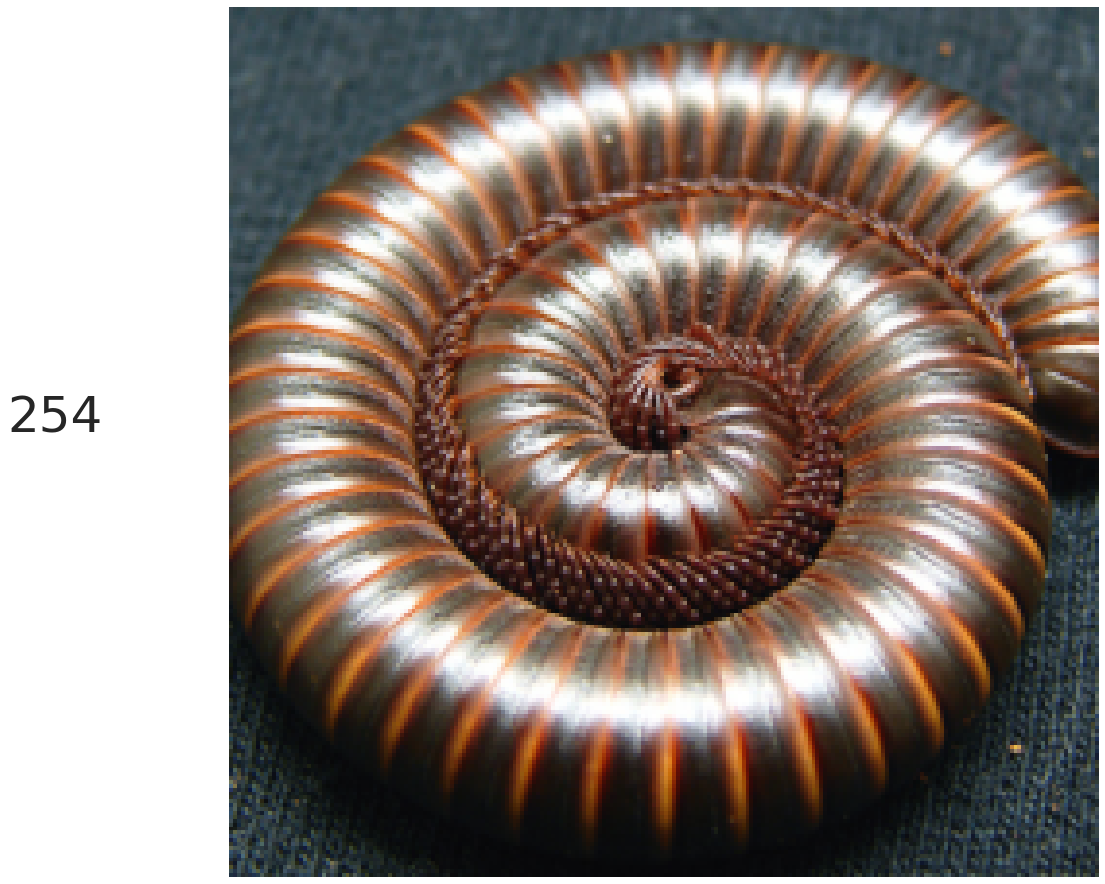

In [9]:
# If you want to export the "trivial" and "impossible" and "inbetwen"images for the second experiment:
if experiment == 2:
    
    # Other random seed for this experiment
    # With seed 1313, images 44, 222, and 254 have to be removed
    np.random.seed(1313)
    
    # +2 samples for each condition for training purposes
    num_samples = num_images + 2
    
    # Trivial items have a mean of 1, as all models got them right, randomly pick "num_samples" amount of images
    trivial_inds = np.random.choice(np.where(mean_decisions_correct == 1)[0], size=num_samples+2, replace=False)

    # Impossible items have mean of 0, as no models got them right, randomly pick "num_samples" amount of images
    impossible_inds = np.random.choice(np.where(mean_decisions_correct == 0)[0], size=num_samples+1, replace=False)

    # In-between items have mean between 0 and 1, randomly pick "num_samples" amount of images
    inbetween_inds = np.random.choice(np.where((mean_decisions_correct > 0) & (mean_decisions_correct < 1))[0],
                                      size=num_samples, replace=False)
    
    # Make order array consisting of zeros, ones and twos and shuffle randomly
    order = np.concatenate((np.zeros(num_samples-2), np.ones(num_samples-2), np.ones(num_samples-2)*2))
    np.random.shuffle(order)
    training_order = np.concatenate((np.zeros(2), np.ones(2), np.ones(2)*2))
    np.random.shuffle(training_order)
    complete_order = np.concatenate((training_order, order))
    
    # Pre-allocate array that stores all of the object category strings
    labels = np.zeros((complete_order.shape), dtype="object")
    indices = np.zeros((complete_order.shape), dtype="object")
                      
    # Init counters
    inbetween_counter = 0
    impossible_counter = 0
    trivial_counter = 0
    
    # Loop through all 306 images
    for index in range(complete_order.shape[0]):

        # Print index
        print(f"Generating image {index+1} of {complete_order.shape[0]}")
                                 
        # For impossible images number in order is 0
        if complete_order[index] == 0:
            image = np.transpose(val_set[impossible_inds[impossible_counter]][0].cpu().detach().numpy(), 
                                 (1, 2, 0))

            # Get image class and up counter by 1
            image_class = idents[impossible_inds[impossible_counter],1].split("/")[0]
            indices[index] = impossible_inds[impossible_counter]
            impossible_counter += 1

        # For inbetween images number in order is 1
        elif complete_order[index] == 1:
            image = np.transpose(val_set[inbetween_inds[inbetween_counter]][0].cpu().detach().numpy(), 
                                 (1, 2, 0))

            # Get image class and up counter by 1
            image_class = idents[inbetween_inds[inbetween_counter],1].split("/")[0]
            indices[index] = inbetween_inds[inbetween_counter]
            inbetween_counter += 1

        # For trivial images number in order is 2
        elif complete_order[index] == 2:
            image = np.transpose(val_set[trivial_inds[trivial_counter]][0].cpu().detach().numpy(), 
                                 (1, 2, 0))

            # Get image class and up counter by 1
            image_class = idents[trivial_inds[trivial_counter],1].split("/")[0]
            indices[index] = trivial_inds[trivial_counter]
            trivial_counter += 1    

        # First six images are training images
        if index < 6:

            # Training images
            plot_exp_2(f"Training_{index+1}", image, training=True, new_indices=new_indices)

        else:

            # Plot test image
            plot_exp_2(index-5, image, training=False, new_indices=new_indices)
        
        # Save object class to array
        labels[index] = str(names[np.where(names[:, 0] == image_class), 1]).split("'")[1]
        
    # Generate crappy images again: image 44 with +5 due to the 6 training images
    index = 49
    image = np.transpose(val_set[trivial_inds[trivial_counter]][0].cpu().detach().numpy(), 
                                 (1, 2, 0))
    image_class = idents[trivial_inds[trivial_counter],1].split("/")[0]
    indices[index] = trivial_inds[trivial_counter]
    trivial_counter += 1 
    labels[index] = str(names[np.where(names[:, 0] == image_class), 1]).split("'")[1]
    plot_exp_2(index-5, image, training=False, new_indices=new_indices)
  
    # Generate crappy images again: image 222 with +5 due to the 6 training images
    index = 227
    image = np.transpose(val_set[trivial_inds[trivial_counter]][0].cpu().detach().numpy(), 
                                 (1, 2, 0))
    image_class = idents[trivial_inds[trivial_counter],1].split("/")[0]
    indices[index] = trivial_inds[trivial_counter]
    trivial_counter += 1    
    labels[index] = str(names[np.where(names[:, 0] == image_class), 1]).split("'")[1]
    plot_exp_2(index-5, image, training=False, new_indices=new_indices)
    
    # Generate crappy images again: image 254 with +5 due to the 6 training images
    index = 259
    image = np.transpose(val_set[impossible_inds[impossible_counter]][0].cpu().detach().numpy(), 
                                 (1, 2, 0))
    image_class = idents[impossible_inds[impossible_counter],1].split("/")[0]
    indices[index] = impossible_inds[impossible_counter]
    impossible_counter += 1 
    labels[index] = str(names[np.where(names[:, 0] == image_class), 1]).split("'")[1]
    plot_exp_2(index-5, image, training=False, new_indices=new_indices)

    # Save answers and labels arrays to same folder
    if new_indices:
        np.save("./experiment2_newerrs/order", order)
        np.save("./experiment2_newerrs/labels", labels)
        np.save("./experiment2_newerrs/indices", indices)
    else:
        np.save("./experiment2/order", order)
        np.save("./experiment2/labels", labels)
        np.save("./experiment2/indices", indices)